In [1]:
!pip install pyvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 44.2 MB/s eta 0:00:00


In [2]:
import pandas as pd
import plotly.graph_objects as go
import networkx as nx
import matplotlib.pyplot as plt
from pyvis.network import Network
import seaborn as sns

In [4]:
# Top Ten Research Collaborators from ETO
pubs = pd.read_csv('eto-export-mena-collab.csv')

# Create a max normed total value column for visualization
pubs['normed_total'] = pubs['Total'] / max(pubs['Total'])
pubs.head()

,Country,Collaborating country,Total,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,normed_total
0,Israel,United States,4670,172,227,241,291,382,588,720,792,491,497,269,1.000000
1,Israel,United Kingdom,1166,36,33,57,64,75,130,177,184,173,150,87,0.249679
2,Israel,Germany,742,25,47,39,47,51,77,82,112,101,107,54,0.158887
3,Israel,Canada,601,30,20,31,34,49,60,97,97,63,76,44,0.128694
4,Israel,France,556,20,26,25,34,49,65,89,85,74,55,34,0.119058


In [ ]:
print(f"Number of Countries included: {pubs['Country'].unique().shape[0]}")
print(f"Number of Collaborating Countries included: {pubs['Collaborating country'].unique().shape[0]}")

Number of Countries included: 20
Number of Collaborating Countries included: 32


In [5]:
# Add labels for ME vs NA
me = [
    'Israel', 'Egypt', 'Iraq', 'Jordan', 'Lebanon', 'Kuwait',
    'Bahrain', 'Saudi Arabia', 'United Arab Emirates', 'Turkey', 'Qatar',
    'Yemen', 'Oman', 'Syria'
]
na = ['Morocco', 'Libya', 'Mauritania', 'Tunisia', 'Algeria', 'Sudan']

pubs['Region'] = pubs['Country'].apply(lambda x: 'Middle East' if x in me else 'North Africa' if x in na else 'Error')

pubs.head()

,Country,Collaborating country,Total,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,normed_total,Region
0,Israel,United States,4670,172,227,241,291,382,588,720,792,491,497,269,1.000000,Middle East
1,Israel,United Kingdom,1166,36,33,57,64,75,130,177,184,173,150,87,0.249679,Middle East
2,Israel,Germany,742,25,47,39,47,51,77,82,112,101,107,54,0.158887,Middle East
3,Israel,Canada,601,30,20,31,34,49,60,97,97,63,76,44,0.128694,Middle East
4,Israel,France,556,20,26,25,34,49,65,89,85,74,55,34,0.119058,Middle East


In [46]:
# Build Weighted Graph for total coauthorships
G = nx.Graph()

# Add nodes for MENA countries
# Weight Node as Sum of Publications w/ Top 10 Collaborators
# Color MENA nodes blue (Dark for ME, light for NA)
# Reduce size by constant factor for visual effect
mena_countries = pubs['Country'].unique()
for country in mena_countries:
  total_collabs = pubs[pubs['Country'] == country]['Total'].sum()
  region = pubs[pubs['Country'] == country]['Region'].iloc[0]
  color = '#332288' if region == 'Middle East' else '#88CCEE'
  G.add_node(
      country,
      label=country,
      font={
          "size": 75,
          "color": "#ffffff"
      },
      size=total_collabs/100.0,
      color=color,
      region=region
  )

# Add nodes for non-MENA countries
# Weight nodes by number of edges
# Color non-MENA nodes blue
# Reduce size by constant factor for visual effect
outside_countries = pubs['Collaborating country'].unique()
outside_countries = [country for country in outside_countries if country not in mena_countries]
for country in outside_countries:
  total_collabs = pubs[pubs['Collaborating country'] == country]['Total'].sum()
  G.add_node(
      country,
      label=country,
      font={
          "size": 75,
          "color": "#ffffff"
      },
      size=total_collabs/100.0,
      color = '#7b7b7b',
      region='Outside'
  )

# Add weighted edges based on max-normed total collaborations
# Reduce weight by constant factor for visual effect
for row in pubs.iterrows():
  G.add_edge(
      row[1]['Country'],
      row[1]['Collaborating country'],
      weight=row[1]['Total']/50.0
  )

In [47]:
# Interactive HTML Plot
net = Network(
    notebook=True,
    directed=False,
    select_menu=True,
    filter_menu=True,
    cdn_resources='remote',
    bgcolor='black'
)
net.barnes_hut(
    gravity=-40000,
    central_gravity=0.5,
    spring_length=100,
    spring_strength=0.01,
    overlap=0.15,
    damping=0.2
)
# net.show_buttons(filter_=['physics'])
net.from_nx(G)
net.write_html('index.html')

In [7]:
# Centrality Calculations

# Degree centrality measures the number of connections a node has
degree_centrality = nx.degree_centrality(G)
top5_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
print("Top 5 Degree Centrality:")
for node, centrality in top5_degree:
    print(f"{node}: {centrality}")

# Closeness centrality measures the avg distance from a node to all other nodes in the graph
closeness_centrality = nx.closeness_centrality(G)
top5_closeness = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
print("\nTop 5 Closeness Centrality:")
for node, centrality in top5_closeness:
    print(f"{node}: {centrality}")

# Betweenness centrality measures how often a node lies on the shortest path between other nodes
betweenness_centrality = nx.betweenness_centrality(G)
top5_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
print("\nTop 5 Betweenness Centrality:")
for node, centrality in top5_betweenness:
    print(f"{node}: {centrality}")

# Eigenvector centrality measures a node's influence based on the influence of its neighbors
eigenvector_centrality = nx.eigenvector_centrality(G)
top5_eigenvector = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
print("\nTop 5 Eigenvector Centrality:")
for node, centrality in top5_eigenvector:
    print(f"{node}: {centrality}")

# Katz centrality measures the influence of a node considering direct and indirect connections
katz_centrality = nx.katz_centrality(G, alpha=0.05)
top5_katz = sorted(katz_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
print("\nTop 5 Katz Centrality:")
for node, centrality in top5_katz:
    print(f"{node}: {centrality}")

# PageRank measures the importance of a node in the network by the number and quality of incoming nodes
pagerank = nx.pagerank(G)
top5_pagerank = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)[:5]
print("\nTop 5 PageRank:")
for node, centrality in top5_pagerank:
    print(f"{node}: {centrality}")

Top 5 Degree Centrality:
Saudi Arabia: 0.5714285714285714
Egypt: 0.45238095238095233
United States: 0.45238095238095233
United Arab Emirates: 0.42857142857142855
United Kingdom: 0.40476190476190477

Top 5 Closeness Centrality:
Saudi Arabia: 0.6461538461538462
United States: 0.6176470588235294
United Kingdom: 0.6
China (mainland): 0.5915492957746479
United Arab Emirates: 0.5753424657534246

Top 5 Betweenness Centrality:
Mauritania: 0.13981568891457152
Saudi Arabia: 0.10184818927055214
Iraq: 0.07968645561869753
Egypt: 0.07861080369311588
Israel: 0.07327802014226222

Top 5 Eigenvector Centrality:
Saudi Arabia: 0.3314433892945562
Egypt: 0.2705242125759309
United Arab Emirates: 0.2672215255766853
United States: 0.2592955795147645
India: 0.24017896850892922

Top 5 Katz Centrality:
Saudi Arabia: 0.27227868447640935
Egypt: 0.23153311720845715
United States: 0.22843858885905505
United Arab Emirates: 0.22783756461383187
India: 0.21377939477325264

Top 5 PageRank:
Saudi Arabia: 0.130383030098183


In [ ]:
# Density of Overall Network
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
max_edges = num_nodes * (num_nodes - 1) / 2

print(f'Network Density: {round(num_edges / max_edges, 4)}')

# Percent of Edges within Region
in_cnt = 0
for edge in G.edges(data=True):
  if edge[0] in mena_countries and edge[1] in mena_countries:
    in_cnt += 1

print(f'Percent of Edges within Region: {round(in_cnt / num_edges, 4)}')

Network Density: 0.2148
Percent of Edges within Region: 0.2268


In [ ]:
# Transitivity: how tightly connected neighborhoods are
print(f'Transitivity: {round(nx.transitivity(G), 4)}')

# Diameter: how many hops in longest path
print(f'Diameter: {nx.diameter(G)}')

# Average Path Length: how many hops on average
print(f'Average Path Length: {round(nx.average_shortest_path_length(G), 4)}')

Transitivity: 0.3293
Diameter: 5
Average Path Length: 2.2436


<ipython-input-22-7fa9a3141639>:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=6)


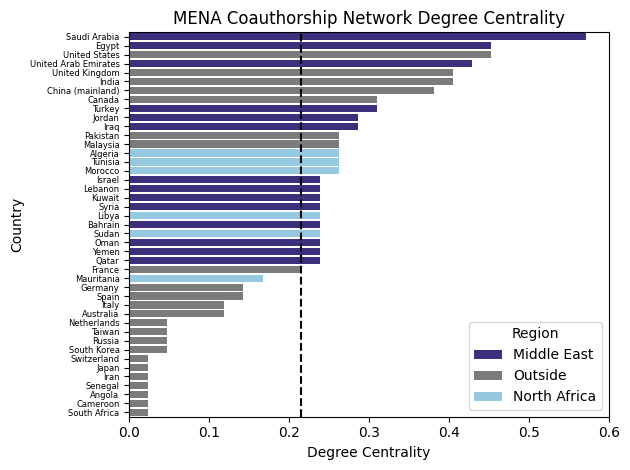

In [22]:
# Histogram of Degree Centrality
dcpd = pd.DataFrame(degree_centrality.items(), columns=['Country', 'Degree Centrality'])
dcpd['Region'] = dcpd['Country'].apply(lambda x: 'Middle East' if x in me else 'North Africa' if x in na else 'Outside')
average_value = dcpd['Degree Centrality'].mean()

colors = {
    'Middle East': '#332288',
    'North Africa': '#88CCEE',
    'Outside': '#7b7b7b'
}
ax = sns.barplot(
    x='Degree Centrality',
    y='Country',
    data=dcpd.sort_values('Degree Centrality', ascending=False),
    hue='Region',
    palette=colors
)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=6)
ax.axvline(average_value, color='black', linestyle='--', label=f'Average: {average_value:.2f}')

plt.xlabel('Degree Centrality')
plt.ylabel('Country')
plt.title('MENA Coauthorship Network Degree Centrality')
plt.tight_layout()
plt.show()

<ipython-input-48-15bb6801734b>:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=6)


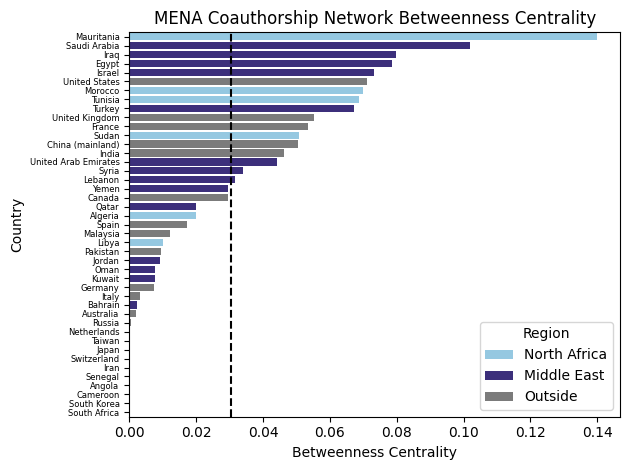

In [48]:
# Histogram of Betweenness Centrality
dcpd = pd.DataFrame(betweenness_centrality.items(), columns=['Country', 'Betweenness Centrality'])
dcpd['Region'] = dcpd['Country'].apply(lambda x: 'Middle East' if x in me else 'North Africa' if x in na else 'Outside')
average_value = dcpd['Betweenness Centrality'].mean()

colors = {
    'Middle East': '#332288',
    'North Africa': '#88CCEE',
    'Outside': '#7b7b7b'
}
ax = sns.barplot(
    x='Betweenness Centrality',
    y='Country',
    data=dcpd.sort_values('Betweenness Centrality', ascending=False),
    hue='Region',
    palette=colors
)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=6)
ax.axvline(average_value, color='black', linestyle='--', label=f'Average: {average_value:.2f}')

plt.xlabel('Betweenness Centrality')
plt.ylabel('Country')
plt.title('MENA Coauthorship Network Betweenness Centrality')
plt.tight_layout()
plt.show()

In [63]:
# Middle East Only
MG = nx.Graph()
for country in me:
  total_collabs = pubs[pubs['Country'] == country]['Total'].sum()
  region = pubs[pubs['Country'] == country]['Region'].iloc[0]
  color = '#332288'
  MG.add_node(
      country,
      label=country,
      font={
          "size": 75,
          "color": "#ffffff"
      },
      size=total_collabs/100.0,
      color=color,
      region=region
  )
outside_countries = pubs[pubs['Region'] == 'Middle East']['Collaborating country'].unique()
outside_countries = [country for country in outside_countries if country not in me]
for country in outside_countries:
  total_collabs = pubs[(pubs['Collaborating country'] == country) & (pubs['Region'] == 'Middle East')]['Total'].sum()

  MG.add_node(
      country,
      label=country,
      font={
          "size": 75,
          "color": "#ffffff"
      },
      size=total_collabs/100.0,
      color = '#88CCEE' if country in na else'#7b7b7b',
      region= 'North Africa' if country in na else 'Outside'
  )
for row in pubs[pubs['Region'] == 'Middle East'].iterrows():
  MG.add_edge(
      row[1]['Country'],
      row[1]['Collaborating country'],
      weight=row[1]['Total']/50.0
  )

net = Network(
    notebook=True,
    directed=False,
    select_menu=True,
    filter_menu=True,
    cdn_resources='remote',
    bgcolor='black'
)
net.barnes_hut(
    gravity=-40000,
    central_gravity=0.5,
    spring_length=100,
    spring_strength=0.01,
    overlap=0.15,
    damping=0.2
)
net.from_nx(MG)
net.write_html('middle-east.html')

In [64]:
degree_centrality = nx.degree_centrality(MG)
top5_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
print("Top 5 Degree Centrality:")
for node, centrality in top5_degree:
    print(f"{node}: {centrality}")
betweenness_centrality = nx.betweenness_centrality(MG)
top5_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
print("\nTop 5 Betweenness Centrality:")
for node, centrality in top5_betweenness:
    print(f"{node}: {centrality}")
eigenvector_centrality = nx.eigenvector_centrality(MG)
top5_eigenvector = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
print("\nTop 5 Eigenvector Centrality:")
for node, centrality in top5_eigenvector:
    print(f"{node}: {centrality}")

num_nodes = MG.number_of_nodes()
num_edges = MG.number_of_edges()
max_edges = num_nodes * (num_nodes - 1) / 2
print(f'\nNetwork Density: {round(num_edges / max_edges, 4)}')
in_cnt = 0
for edge in MG.edges(data=True):
  if edge[0] in me and edge[1] in me:
    in_cnt += 1
print(f'\nPercent of Edges within Region: {round(in_cnt / num_edges, 4)}')
print(f'\nTransitivity: {round(nx.transitivity(MG), 4)}')
print(f'\nDiameter: {nx.diameter(MG)}')
print(f'\nAverage Path Length: {round(nx.average_shortest_path_length(MG), 4)}')

Top 5 Degree Centrality:
Saudi Arabia: 0.5882352941176471
Egypt: 0.47058823529411764
United Arab Emirates: 0.4411764705882353
United States: 0.4117647058823529
China (mainland): 0.38235294117647056

Top 5 Betweenness Centrality:
Saudi Arabia: 0.14898403726740186
Turkey: 0.11571017335661941
Israel: 0.10965584808018908
Iraq: 0.1065028373618977
Egypt: 0.10082087674966933

Top 5 Eigenvector Centrality:
Saudi Arabia: 0.34243151733737026
Egypt: 0.28653490100150897
United Arab Emirates: 0.2864748715371909
United States: 0.25543075523833453
India: 0.24685030327995425

Network Density: 0.2319

Percent of Edges within Region: 0.1957

Transitivity: 0.3561

Diameter: 4

Average Path Length: 2.1176


<ipython-input-56-b9481f07b7f3>:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=6)


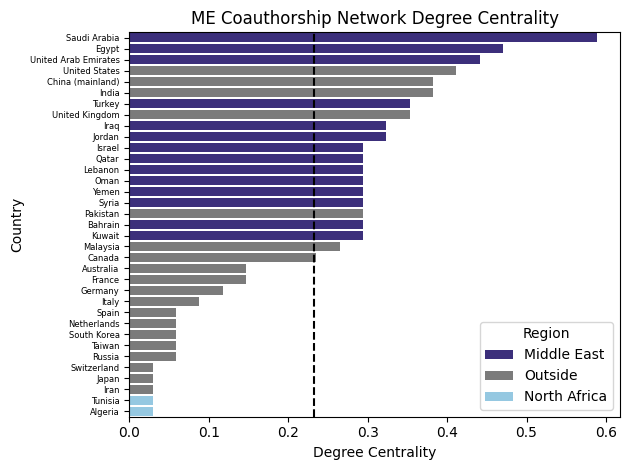

In [56]:
# Histogram of Degree Centrality (Middle East)
dcpd = pd.DataFrame(degree_centrality.items(), columns=['Country', 'Degree Centrality'])
dcpd['Region'] = dcpd['Country'].apply(lambda x: 'Middle East' if x in me else 'North Africa' if x in na else 'Outside')
average_value = dcpd['Degree Centrality'].mean()

colors = {
    'Middle East': '#332288',
    'North Africa': '#88CCEE',
    'Outside': '#7b7b7b'
}
ax = sns.barplot(
    x='Degree Centrality',
    y='Country',
    data=dcpd.sort_values('Degree Centrality', ascending=False),
    hue='Region',
    palette=colors
)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=6)
ax.axvline(average_value, color='black', linestyle='--', label=f'Average: {average_value:.2f}')

plt.xlabel('Degree Centrality')
plt.ylabel('Country')
plt.title('ME Coauthorship Network Degree Centrality')
plt.tight_layout()
plt.show()

<ipython-input-58-3868ac094ce9>:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=6)


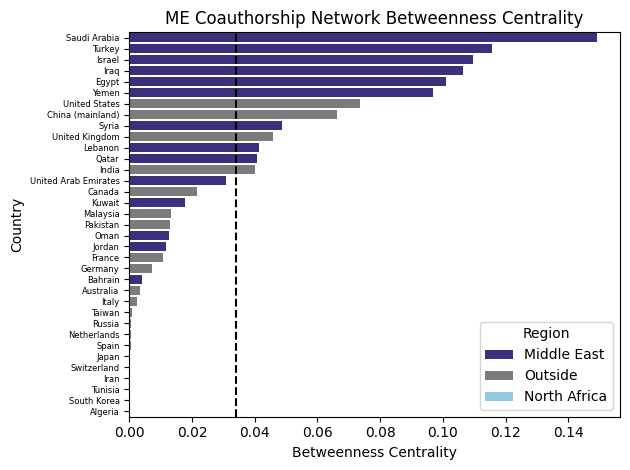

In [58]:
# Histogram of Betweenness Centrality (Middle East)
dcpd = pd.DataFrame(betweenness_centrality.items(), columns=['Country', 'Betweenness Centrality'])
dcpd['Region'] = dcpd['Country'].apply(lambda x: 'Middle East' if x in me else 'North Africa' if x in na else 'Outside')
average_value = dcpd['Betweenness Centrality'].mean()

colors = {
    'Middle East': '#332288',
    'North Africa': '#88CCEE',
    'Outside': '#7b7b7b'
}
ax = sns.barplot(
    x='Betweenness Centrality',
    y='Country',
    data=dcpd.sort_values('Betweenness Centrality', ascending=False),
    hue='Region',
    palette=colors
)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=6)
ax.axvline(average_value, color='black', linestyle='--', label=f'Average: {average_value:.2f}')

plt.xlabel('Betweenness Centrality')
plt.ylabel('Country')
plt.title('ME Coauthorship Network Betweenness Centrality')
plt.tight_layout()
plt.show()

In [67]:
# North Africa Only
NG = nx.Graph()
for country in na:
  total_collabs = pubs[pubs['Country'] == country]['Total'].sum()
  region = pubs[pubs['Country'] == country]['Region'].iloc[0]
  color = '#88CCEE'
  NG.add_node(
      country,
      label=country,
      font={
          "size": 75,
          "color": "#ffffff"
      },
      size=total_collabs/100.0,
      color=color,
      region=region
  )
outside_countries = pubs[pubs['Region'] == 'North Africa']['Collaborating country'].unique()
outside_countries = [country for country in outside_countries if country not in na]
for country in outside_countries:
  total_collabs = pubs[(pubs['Collaborating country'] == country) & (pubs['Region'] == 'North Africa')]['Total'].sum()

  NG.add_node(
      country,
      label=country,
      font={
          "size": 75,
          "color": "#ffffff"
      },
      size=total_collabs/100.0,
      color = '#332288' if country in me else'#7b7b7b',
      region= 'Middle East' if country in me else 'Outside'
  )
for row in pubs[pubs['Region'] == 'North Africa'].iterrows():
  NG.add_edge(
      row[1]['Country'],
      row[1]['Collaborating country'],
      weight=row[1]['Total']/50.0
  )

net = Network(
    notebook=True,
    directed=False,
    select_menu=True,
    filter_menu=True,
    cdn_resources='remote',
    bgcolor='black'
)
net.barnes_hut(
    gravity=-40000,
    central_gravity=0.5,
    spring_length=100,
    spring_strength=0.01,
    overlap=0.15,
    damping=0.2
)
net.from_nx(NG)
net.write_html('north-africa.html')

In [ ]:
degree_centrality = nx.degree_centrality(NG)
top5_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
print("Top 5 Degree Centrality:")
for node, centrality in top5_degree:
    print(f"{node}: {centrality}")
betweenness_centrality = nx.betweenness_centrality(NG)
top5_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
print("\nTop 5 Betweenness Centrality:")
for node, centrality in top5_betweenness:
    print(f"{node}: {centrality}")
eigenvector_centrality = nx.eigenvector_centrality(NG)
top5_eigenvector = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
print("\nTop 5 Eigenvector Centrality:")
for node, centrality in top5_eigenvector:
    print(f"{node}: {centrality}")

num_nodes = NG.number_of_nodes()
num_edges = NG.number_of_edges()
max_edges = num_nodes * (num_nodes - 1) / 2
print(f'\nNetwork Density: {round(num_edges / max_edges, 4)}')
in_cnt = 0
for edge in NG.edges(data=True):
  if edge[0] in me and edge[1] in me:
    in_cnt += 1
print(f'\nPercent of Edges within Region: {round(in_cnt / num_edges, 4)}')
print(f'\nTransitivity: {round(nx.transitivity(NG), 4)}')
# print(f'\nDiameter: {nx.diameter(NG)}')
# print(f'\nAverage Path Length: {round(nx.average_shortest_path_length(NG), 4)}')

<ipython-input-61-1091a6517222>:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=6)


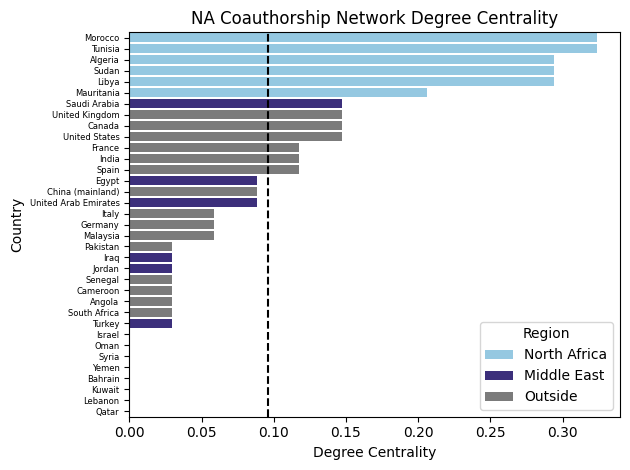

In [61]:
# Histogram of Degree Centrality (North Africa)
dcpd = pd.DataFrame(degree_centrality.items(), columns=['Country', 'Degree Centrality'])
dcpd['Region'] = dcpd['Country'].apply(lambda x: 'Middle East' if x in me else 'North Africa' if x in na else 'Outside')
average_value = dcpd['Degree Centrality'].mean()

colors = {
    'Middle East': '#332288',
    'North Africa': '#88CCEE',
    'Outside': '#7b7b7b'
}
ax = sns.barplot(
    x='Degree Centrality',
    y='Country',
    data=dcpd.sort_values('Degree Centrality', ascending=False),
    hue='Region',
    palette=colors
)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=6)
ax.axvline(average_value, color='black', linestyle='--', label=f'Average: {average_value:.2f}')

plt.xlabel('Degree Centrality')
plt.ylabel('Country')
plt.title('NA Coauthorship Network Degree Centrality')
plt.tight_layout()
plt.show()

<ipython-input-62-3868ac094ce9>:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=6)


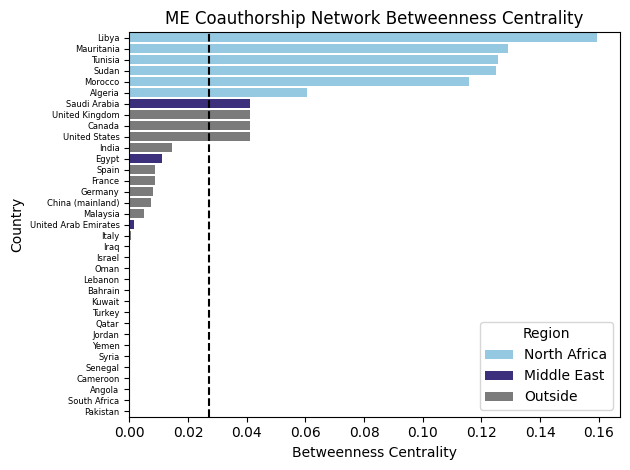

In [62]:
# Histogram of Betweenness Centrality
dcpd = pd.DataFrame(betweenness_centrality.items(), columns=['Country', 'Betweenness Centrality'])
dcpd['Region'] = dcpd['Country'].apply(lambda x: 'Middle East' if x in me else 'North Africa' if x in na else 'Outside')
average_value = dcpd['Betweenness Centrality'].mean()

colors = {
    'Middle East': '#332288',
    'North Africa': '#88CCEE',
    'Outside': '#7b7b7b'
}
ax = sns.barplot(
    x='Betweenness Centrality',
    y='Country',
    data=dcpd.sort_values('Betweenness Centrality', ascending=False),
    hue='Region',
    palette=colors
)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=6)
ax.axvline(average_value, color='black', linestyle='--', label=f'Average: {average_value:.2f}')

plt.xlabel('Betweenness Centrality')
plt.ylabel('Country')
plt.title('ME Coauthorship Network Betweenness Centrality')
plt.tight_layout()
plt.show()